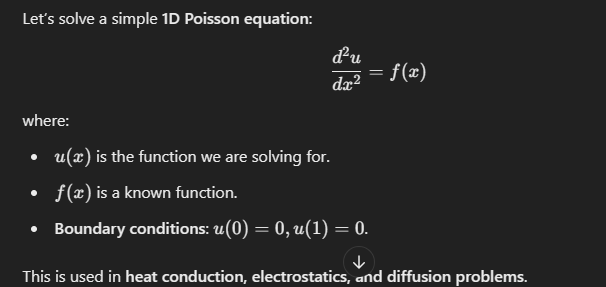

a simple fully connected neural network (FCNN) to approximate 
𝑢(𝑥)
u(x).

In [1]:
import torch

In [2]:
import torch.nn as nn
import numpy as np

# Neural Network (FCNN)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)


We need a custom loss function that combines:

Physics Loss (ensuring the PDE is satisfied)
Boundary Conditions Loss
Data Loss (if available)

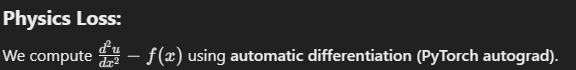

In [3]:
# Define Physics Loss (PDE Residual)
def physics_loss(model, x):
    x.requires_grad = True  # Enable autograd
    u = model(x)  # Predict u(x)

    # Compute First Derivative (du/dx)
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Compute Second Derivative (d²u/dx²)
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    
    # Define source function f(x) (Poisson equation)
    f_x = torch.sin(np.pi * x)  # Example forcing function
    
    # Physics residual (should be close to 0)
    residual = d2u_dx2 - f_x # loss or error 
    return torch.mean(residual ** 2)  # Mean Squared Error


In [ ]:

# grad_outputs=torch.ones_like(u) is a parameter used in the torch.autograd.grad() function.
# Here's what it does:
# grad_outputs:
# The grad_outputs parameter specifies the gradient outputs with respect to which the gradients of the inputs are computed.
# In other words, it tells PyTorch what gradients to backpropagate through the computation graph.
# torch.ones_like(u):
# torch.ones_like(u) creates a tensor of ones with the same shape and size as the tensor u.
# By passing torch.ones_like(u) as the grad_outputs parameter, PyTorch will compute the gradients of the inputs with respect to the output u, assuming that the gradient of the loss function with respect to u is a tensor of ones.
# Why use torch.ones_like(u)?:
# Using torch.ones_like(u) as the grad_outputs parameter is equivalent to computing the gradient of the loss function with respect to u assuming that the loss function is simply the sum of the elements of u.
# This is a common assumption in many optimization problems, where the goal is to minimize or maximize the sum of the elements of the output tensor.

In [ ]:
# This is a PyTorch implementation of a physics-informed neural network (PINN) loss function for solving a Poisson equation. Here's a breakdown of the code:
# Poisson Equation:
# The Poisson equation is a partial differential equation (PDE) of the form:
# ∇²u(x) = f(x)
# where:
# u(x) is the unknown function to be approximated.
# f(x) is the source function or forcing term.
# ∇² is the Laplace operator, representing the second derivative.
# PINN Loss Function:
# The PINN loss function is designed to enforce the Poisson equation on the neural network's predictions. The loss function consists of two parts:
# Physics residual: This term measures how well the neural network's predictions satisfy the Poisson equation.
# Data fidelity: This term measures how well the neural network's predictions match the available data (if any).
# In this implementation, only the physics residual term is considered.
# Code Explanation:
# Here's a step-by-step explanation of the code:
# Enable autograd: x.requires_grad = True enables automatic differentiation for the input tensor x.
# Predict u(x): u = model(x) predicts the value of the unknown function u(x) using the neural network model.
# Compute first derivative: du_dx = torch.autograd.grad(u, x, ...)[0] computes the first derivative of u(x) with respect to x using automatic differentiation.
# Compute second derivative: d2u_dx2 = torch.autograd.grad(du_dx, x, ...)[0] computes the second derivative of u(x) with respect to x using automatic differentiation.
# Define source function: f_x = torch.sin(np.pi * x) defines the source function f(x) as a sine wave.
# Compute physics residual: residual = d2u_dx2 - f_x computes the physics residual by subtracting the source function from the predicted second derivative.
# Compute mean squared error: torch.mean(residual ** 2) computes the mean squared error of the physics residual.
# The final output of the function is the mean squared error of the physics residual, which represents the loss or error of the neural network's predictions with respect to the Poisson equation.

In [4]:
def boundary_loss(model):
    u0 = model(torch.tensor([[0.0]], dtype=torch.float32))  # u(0)
    u1 = model(torch.tensor([[1.0]], dtype=torch.float32))  # u(1)
    return u0.pow(2) + u1.pow(2)  # Enforce u(0) = 0 and u(1) = 0


In [ ]:

# This is a PyTorch implementation of a boundary loss function for a neural network model. Here's a breakdown of the code:
# Boundary Conditions:
# The boundary loss function is designed to enforce specific boundary conditions on the neural network's output. In this case, the boundary conditions are:
# u(0) = 0
# u(1) = 0
# These conditions specify that the output of the neural network should be zero at the input values x=0 and x=1.
# Code Explanation:
# Here's a step-by-step explanation of the code:
# Evaluate the model at x=0: u0 = model(torch.tensor([[0.0]], dtype=torch.float32))
# This line evaluates the neural network model at the input value x=0.
# The output is stored in the variable u0.
# Evaluate the model at x=1: u1 = model(torch.tensor([[1.0]], dtype=torch.float32))
# This line evaluates the neural network model at the input value x=1.
# The output is stored in the variable u1.
# Compute the boundary loss: return u0.pow(2) + u1.pow(2)
# This line computes the boundary loss by summing the squared values of u0 and u1.
# The squared values are used to penalize non-zero outputs at the boundary points.
# Purpose:
# The purpose of this boundary loss function is to regularize the neural network's output to satisfy the specified boundary conditions. By adding this loss term to the overall loss function, the neural network is encouraged to produce outputs that are close to zero at the boundary points.

In [5]:
def total_loss(model, x):
    return physics_loss(model, x) + boundary_loss(model)


train using Gradient Descent (Adam optimizer).

In [18]:
torch.linspace(0, 1, 100).reshape(-1, 1)

tensor([[0.0000],
        [0.0101],
        [0.0202],
        [0.0303],
        [0.0404],
        [0.0505],
        [0.0606],
        [0.0707],
        [0.0808],
        [0.0909],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818],
        [0.1919],
        [0.2020],
        [0.2121],
        [0.2222],
        [0.2323],
        [0.2424],
        [0.2525],
        [0.2626],
        [0.2727],
        [0.2828],
        [0.2929],
        [0.3030],
        [0.3131],
        [0.3232],
        [0.3333],
        [0.3434],
        [0.3535],
        [0.3636],
        [0.3737],
        [0.3838],
        [0.3939],
        [0.4040],
        [0.4141],
        [0.4242],
        [0.4343],
        [0.4444],
        [0.4545],
        [0.4646],
        [0.4747],
        [0.4848],
        [0.4949],
        [0.5051],
        [0.5152],
        [0.5253],
        [0.5354],
        [0.5455],
        [0

In [ ]:
# This code generates a tensor x containing 100 evenly spaced points between 0 and 1, and then enables automatic differentiation for this tensor.
# Here's a breakdown of the code:
# torch.linspace:
# torch.linspace(0, 1, 100) generates a tensor containing 100 evenly spaced values between 0 and 1.
# reshape:
# .reshape(-1, 1) reshapes the tensor into a 2D tensor with shape (100, 1). The -1 in the reshape method tells PyTorch to infer the size of the first dimension.
# requires_grad_:
# .requires_grad_(True) enables automatic differentiation for the tensor x. This means that PyTorch will track the gradients of x during the forward pass, allowing you to compute the gradients of the loss with respect to x during the backward pass.

In [ ]:
import torch.optim as optim

# Training Data (Physics Points)
x = torch.linspace(0, 1, 100).reshape(-1, 1)  # 100 Points in [0,1]
x = x.requires_grad_(True)  # Enable gradient tracking

# Initialize Model and Optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, x)
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training Complete!")


Epoch 0, Loss: 0.635063
Epoch 5, Loss: 0.369133
Epoch 10, Loss: 0.138700
Epoch 15, Loss: 0.101222
Epoch 20, Loss: 0.038669
Epoch 25, Loss: 0.007076
Epoch 30, Loss: 0.004627
Epoch 35, Loss: 0.008793
Epoch 40, Loss: 0.005103
Epoch 45, Loss: 0.000452
Training Complete!


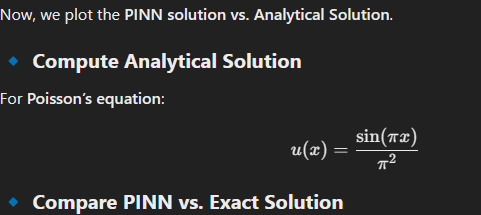

In [19]:
torch.linspace(0, 1, 100).reshape(-1, 1)

tensor([[0.0000],
        [0.0101],
        [0.0202],
        [0.0303],
        [0.0404],
        [0.0505],
        [0.0606],
        [0.0707],
        [0.0808],
        [0.0909],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818],
        [0.1919],
        [0.2020],
        [0.2121],
        [0.2222],
        [0.2323],
        [0.2424],
        [0.2525],
        [0.2626],
        [0.2727],
        [0.2828],
        [0.2929],
        [0.3030],
        [0.3131],
        [0.3232],
        [0.3333],
        [0.3434],
        [0.3535],
        [0.3636],
        [0.3737],
        [0.3838],
        [0.3939],
        [0.4040],
        [0.4141],
        [0.4242],
        [0.4343],
        [0.4444],
        [0.4545],
        [0.4646],
        [0.4747],
        [0.4848],
        [0.4949],
        [0.5051],
        [0.5152],
        [0.5253],
        [0.5354],
        [0.5455],
        [0

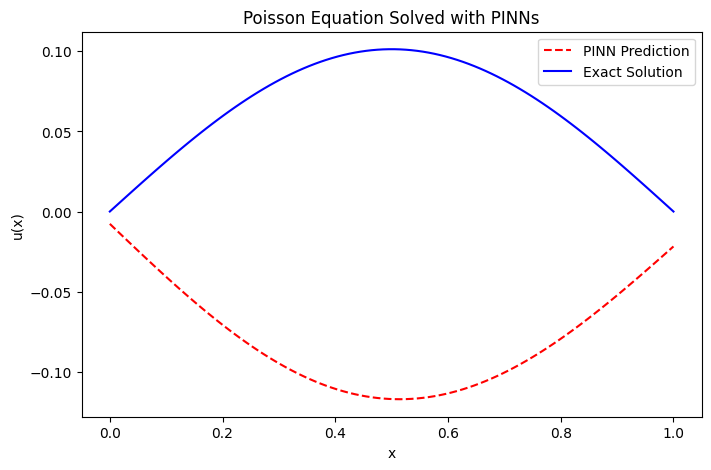

In [8]:
import matplotlib.pyplot as plt

# Test Points
x_test = torch.linspace(0, 1, 100).reshape(-1, 1)

# Predictions from PINN
with torch.no_grad():
    u_pred = model(x_test).numpy()

# Exact Solution
u_exact = (np.sin(np.pi * x_test.numpy()) / (np.pi ** 2))

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(x_test.numpy(), u_pred, label="PINN Prediction", linestyle="dashed", color="red")
plt.plot(x_test.numpy(), u_exact, label="Exact Solution", color="blue")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Poisson Equation Solved with PINNs")
plt.show()


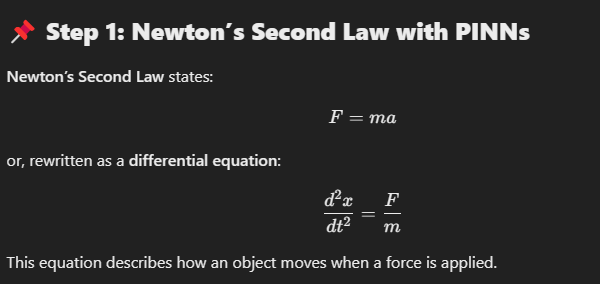

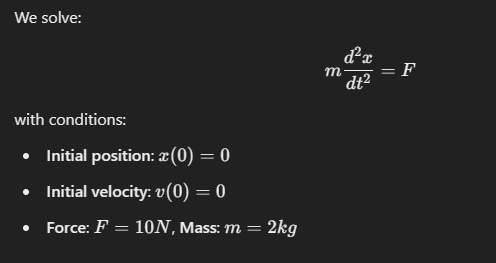

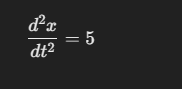

We use a simple neural network to approximate 
𝑥(
𝑡
)


In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define Neural Network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)


To enforce Newton’s Second Law, we use automatic differentiation

In [10]:
# Define Physics Loss
def physics_loss(model, t):
    t.requires_grad = True  # Enable autograd
    x = model(t)  # Predict position x(t)

    # Compute velocity (dx/dt)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

    # Compute acceleration (d²x/dt²)
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]

    # Physics residual: d²x/dt² - 5 = 0
    residual = d2x_dt2 - 5 # loss

    return torch.mean(residual**2)


Boundary Condition Loss
PINNs should satisfy initial conditions:

x(0)=0


v(0)=0

In [11]:
# Define Boundary Loss
def boundary_loss(model):
    t0 = torch.tensor([[0.0]], requires_grad=True, dtype=torch.float32)
    x0 = model(t0)  # x(0)
    
    # Compute velocity at t=0
    dx_dt0 = torch.autograd.grad(x0, t0, grad_outputs=torch.ones_like(x0), create_graph=True)[0]

    return x0.pow(2) + dx_dt0.pow(2)  # Enforce x(0)=0, v(0)=0


In [13]:
torch.linspace(0, 5, 100).reshape(-1, 1)

tensor([[0.0000],
        [0.0505],
        [0.1010],
        [0.1515],
        [0.2020],
        [0.2525],
        [0.3030],
        [0.3535],
        [0.4040],
        [0.4545],
        [0.5051],
        [0.5556],
        [0.6061],
        [0.6566],
        [0.7071],
        [0.7576],
        [0.8081],
        [0.8586],
        [0.9091],
        [0.9596],
        [1.0101],
        [1.0606],
        [1.1111],
        [1.1616],
        [1.2121],
        [1.2626],
        [1.3131],
        [1.3636],
        [1.4141],
        [1.4646],
        [1.5152],
        [1.5657],
        [1.6162],
        [1.6667],
        [1.7172],
        [1.7677],
        [1.8182],
        [1.8687],
        [1.9192],
        [1.9697],
        [2.0202],
        [2.0707],
        [2.1212],
        [2.1717],
        [2.2222],
        [2.2727],
        [2.3232],
        [2.3737],
        [2.4242],
        [2.4747],
        [2.5253],
        [2.5758],
        [2.6263],
        [2.6768],
        [2.7273],
        [2

In [16]:
# Combine Losses
def total_loss(model, t):
    return physics_loss(model, t) + boundary_loss(model)

# Training
t_train = torch.linspace(0, 5, 100).reshape(-1, 1)  # Training time points

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, t_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training Complete!")


Epoch 0, Loss: 24.521612
Epoch 5, Loss: 24.064314
Epoch 10, Loss: 23.619381
Epoch 15, Loss: 22.894943
Epoch 20, Loss: 21.594051
Epoch 25, Loss: 19.696404
Epoch 30, Loss: 17.320114
Epoch 35, Loss: 14.975681
Epoch 40, Loss: 13.124797
Epoch 45, Loss: 11.443754
Epoch 50, Loss: 10.457658
Epoch 55, Loss: 9.107302
Epoch 60, Loss: 7.970492
Epoch 65, Loss: 6.901100
Epoch 70, Loss: 6.186014
Epoch 75, Loss: 5.515659
Epoch 80, Loss: 5.269053
Epoch 85, Loss: 4.891933
Epoch 90, Loss: 4.299277
Epoch 95, Loss: 3.536842
Epoch 100, Loss: 3.461545
Epoch 105, Loss: 2.840307
Epoch 110, Loss: 2.543589
Epoch 115, Loss: 2.315213
Epoch 120, Loss: 1.999321
Epoch 125, Loss: 1.759672
Epoch 130, Loss: 1.461740
Epoch 135, Loss: 1.272062
Epoch 140, Loss: 7.505037
Epoch 145, Loss: 2.275540
Epoch 150, Loss: 2.177802
Epoch 155, Loss: 1.779939
Epoch 160, Loss: 1.426692
Epoch 165, Loss: 1.072043
Epoch 170, Loss: 0.803253
Epoch 175, Loss: 0.635663
Epoch 180, Loss: 0.542227
Epoch 185, Loss: 0.462676
Epoch 190, Loss: 0.3907

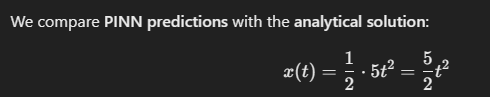

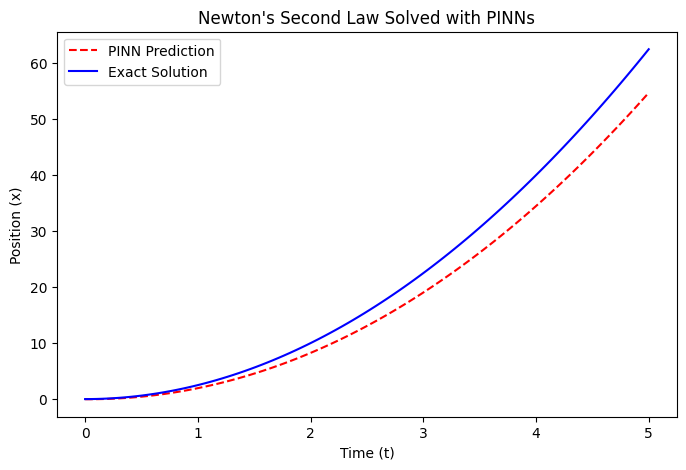

In [17]:
# Test Points
t_test = torch.linspace(0, 5, 100).reshape(-1, 1)

# PINN Predictions
with torch.no_grad():
    x_pred = model(t_test).numpy()

# Exact Solution: x = (5/2) t^2
x_exact = (5/2) * t_test.numpy()**2

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(t_test.numpy(), x_pred, label="PINN Prediction", linestyle="dashed", color="red")
plt.plot(t_test.numpy(), x_exact, label="Exact Solution", color="blue")
plt.xlabel("Time (t)")
plt.ylabel("Position (x)")
plt.legend()
plt.title("Newton's Second Law Solved with PINNs")
plt.show()
